## Data import

In [2]:
import numpy as np
import seaborn as sb
import tensorflow
import pandas as pd
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [3]:
(X_train,y_train), ( X_test, y_test) = tensorflow.keras.datasets.mnist.load_data()


11493376/11490434 [==============================] - 3s 0us/step


In [4]:
X_train = np.reshape(X_train, (60000,784))
X_test = np.reshape(X_test, (10000,784))

For better work, I reduced the data by 75%

In [5]:
X_train = X_train[:5000][:]
y_train = y_train[:5000]

## Training models

### Selecting classifiers

In [6]:

models = {
    'knn': KNeighborsClassifier(),
    'decision_tree': DecisionTreeClassifier(),
    'random_forest': RandomForestClassifier(),
    'svc': SVC(),
    'mlp': MLPClassifier(),
    'bayes': GaussianNB()
}

In [7]:
names_models = {
    'knn': 'KNeighborsClassifier',
    'decision_tree': 'DecisionTreeClassifier',
    'random_forest': 'RandomForestClassifier',
    'svc': 'SVC',
    'mlp': 'MLPClassifier',
    'bayes': 'GaussianNB'
}

### Training classifiers

In [8]:
accuracies = []
classifiers = []
for i in models:
    clf = models[i].fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)
    print(f'Accuracy {names_models[i]} = {accuracy_score(y_test, y_predict)}')
    accuracies.append(accuracy)
    classifiers.append(names_models[i])

Accuracy KNeighborsClassifier = 0.9325
Accuracy DecisionTreeClassifier = 0.7752
Accuracy RandomForestClassifier = 0.9375
Accuracy SVC = 0.9513
Accuracy MLPClassifier = 0.8744
Accuracy GaussianNB = 0.58


MLP has a lower than expected result, I made a modification in the number of layers to check if there is any change in the accuracy value

In [9]:
clf = MLPClassifier(hidden_layer_sizes=(1000,), max_iter=1000)
clf.fit(X_train, y_train)
accuracy = accuracy_score(y_test, clf.predict(X_test))
print(f'Accuracy: {accuracy}')
accuracies.append(accuracy)
classifiers.append('MLPClassifier 1000 Layers')

Accuracy: 0.9301


With 1000 layers, greater accuracy compared to the test with standard hyperparameters

### Plot results

In [10]:
dataframe = pd.DataFrame({
    'Classifiers': classifiers,
    'Accuracies':accuracies
})

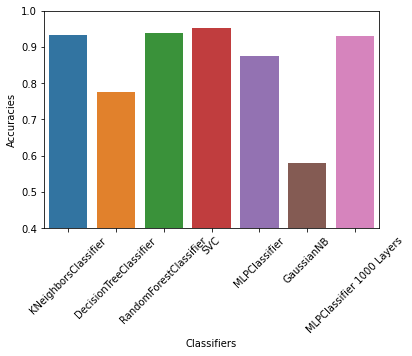

In [11]:
ax = sb.barplot(data=dataframe, x='Classifiers', y='Accuracies')
ax.set(ylim=(0.4,1))
ax.tick_params(axis='x', rotation=45)

<p> As expected, Decision Tree and Naive Bayes classifiers are much less accurate than other classifiers.
<p> Now let's try to improve other classifiers
<p> SVC and MLP are responsible for ​​80% of the execution time

## Improve classifiers

### Filtering the best classifiers and setting parameters

In [12]:
models = {
    'knn': KNeighborsClassifier(),
    'random_forest': RandomForestClassifier(),
    'svc': SVC(),
    'mlp': MLPClassifier()
}

In [13]:
params = {
    'knn': {'n_neighbors':[1,3,5,7]},
    'random_forest': {'criterion': ['gini','entropy'], 'n_estimators':[50,100,150,200]},
    'svc': {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'gamma':['scale','auto'], 'degree':[2,3,4]},
    'mlp': {'solver':['sgd', 'adam'], 'hidden_layer_sizes':[(1000,), (500,500), (1200,400)], 'max_iter':[1000]},
}

### Randomized Search for best models in prev section

In [14]:
best_accuracy = 0

for i in models:
    clf = RandomizedSearchCV(models[i], params[i], n_iter=4).fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)
    print(f'Accuracy {names_models[i]} = {accuracy_score(y_test, y_predict)}')
    print(f'Best params {clf.best_params_}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_classifier = clf

Accuracy KNeighborsClassifier = 0.9343
Best params {'n_neighbors': 1}
Accuracy RandomForestClassifier = 0.9405
Best params {'n_estimators': 150, 'criterion': 'entropy'}
Accuracy SVC = 0.9513
Best params {'kernel': 'rbf', 'gamma': 'scale', 'degree': 4}
Accuracy MLPClassifier = 0.9289
Best params {'solver': 'adam', 'max_iter': 1000, 'hidden_layer_sizes': (1200, 400)}


## Normalizing and standardizing best classifier

In [15]:
accuracies = [best_accuracy]
classifiers = ['Unchanged', 'Normalized', 'Standardized']

### Normalizing

In [16]:
X_train_normalized = Normalizer().fit(X_train).transform(X_train)
X_test_normalized = Normalizer().fit(X_train).transform(X_test)

In [17]:
clf = best_classifier.best_estimator_
clf.fit(X_train_normalized, y_train)
accuracy = accuracy_score(y_test, clf.predict(X_test_normalized))
print(f'Accuracy with data normalized {accuracy}')
accuracies.append(accuracy)


Accuracy with data normalized 0.954


### Standardizing

In [18]:
X_train_standardizing =StandardScaler().fit(X_train).transform(X_train)
X_test_standardizing = StandardScaler().fit(X_train).transform(X_test)

In [19]:
clf = best_classifier.best_estimator_
clf.fit(X_train_standardizing, y_train)
accuracy = accuracy_score(y_test, clf.predict(X_test_standardizing))
print(f'Accuracy with data standardized {accuracy}')
accuracies.append(accuracy)

Accuracy with data standardized 0.923


### Plot results

In [20]:
dataframe = pd.DataFrame({
    'Classifiers': classifiers,
    'Accuracies':accuracies
})

[(0.5, 0.98)]

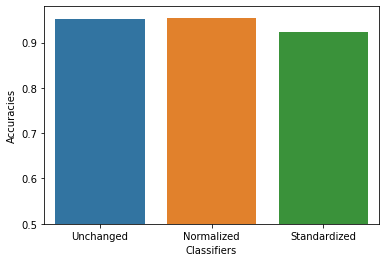

In [21]:
ax = sb.barplot(data=dataframe, x='Classifiers', y='Accuracies')
ax.set(ylim=(0.5,0.98))

In this example, the normalization affected the accuracy result, being very interesting to implement it. Regarding standardization, it may not bring satisfactory results, sometimes it may even decrease the accuracy value.

## Kmeans

In [22]:
clf = KMeans(n_clusters=10).fit(X_train)

In [23]:
y_predict = clf.predict(X_test)

<AxesSubplot:ylabel='count'>

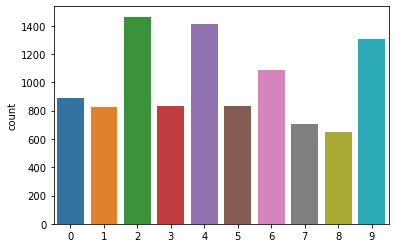

In [24]:
sb.countplot(x=y_predict)

The dataset with many classes is quite complicated to identify the real class.

## TSNE

In [25]:
X_embedded = TSNE().fit_transform(X_train)

/home/geovane/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/geovane/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [26]:
plt.scatter(df[0], df[1], c=y_train)

NameError: name 'df' is not defined

With TSNE it is easy to recognize class groups. But I still haven't been able to make a header with the classes and colors

## Results

As we can see in the graphics, using random search to increase the accuracy of the classifiers ended up having no effect. Using normalization had a small gain in accuracy, so it's interesting to implement it.